In [2]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
af_path_old = '/home/greg/sftp/eddyflux/Ameriflux_files/'

import os
import load_nmeg as ld
import transform_nmeg as tr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import datetime as dt
import pdb as pdb
%matplotlib inline

# Discrepacies in 2009 LE/ET values at PJG

When we look at cumulative ET in 2009 at PJ_girdle, this value is quite a bit higher than at PJ control (~50mm). There are a couple things that could be to blame for this:

1. There was a bad irga at the site prior to Sept 1st. It appears that this is corrected using a linear regression to a good irga. See the documentation in the flux processing manual and the corrections in applied in UNM_flux_031010.m. It is possible this correction to LE was not needed.
    
2. There is no PJG data until Feb 23 2009, so all data is gapfilled. Fc gapfilling (done by MPI eddyproc) was improved by patching PJG Fc with a 2 wk period of PJC data (in January), but this has not been tried at for LE, which is also gapfilled during this period.
    
To look at these possibilities I have created several versions of the Ameriflux data. One file with the bad irga correction applied, but no PJG gapfilling LE patch using PJC. One file with no bad irga correction applied (to LE) and no gapfilling LE patch. One file with the bad irga correction and a LE gapfilling patch applied.

In [3]:
# First get standard ameriflux data - Fc corrected, no correction to LE, both patches
std_2009 = ld.load_aflx_file( af_path + 'US-Mpg_2009_gapfilled.txt', 2009)
# Convert to daily
dg = tr.resample_30min_aflx( std_2009, freq='1D',
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 

# then get ameriflux data with no correction to LE or FC
uncorr_2009 = ld.load_aflx_file( af_path + 'US-Mpg_2009_gapfilled_lefc_uncorr.txt', 2009)
# Convert to daily
fc_nocor_dg = tr.resample_30min_aflx( uncorr_2009, freq='1D',
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 

# Ameriflux data with LE corrected, but the LE gapfilling not patched from PJC
nopatch_2009 = ld.load_aflx_file( af_path + 'US-Mpg_2009_gapfilled_le_nopatch.txt', 2009)
le_cor_nop_dg = tr.resample_30min_aflx(nopatch_2009, freq='1D',
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 

# Ameriflux data wtih LE corrected and LE gapfilling patched
lecorrpatch_2009 = ld.load_aflx_file( af_path + 'US-Mpg_2009_gapfilled_le_corr.txt', 2009)
le_cor_p_dg = tr.resample_30min_aflx( lecorrpatch_2009, freq='1D',
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' )

# Ameriflux data for PJ control, for comparison
control = ld.load_aflx_file( af_path + 'US-Mpj_2009_gapfilled.txt', 2009)
dc = tr.resample_30min_aflx( control, freq='1D',
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET_F', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' )

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled_lefc_uncorr.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled_le_nopatch.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled_le_corr.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2009_gapfilled.txt


## Compare 24h ET data

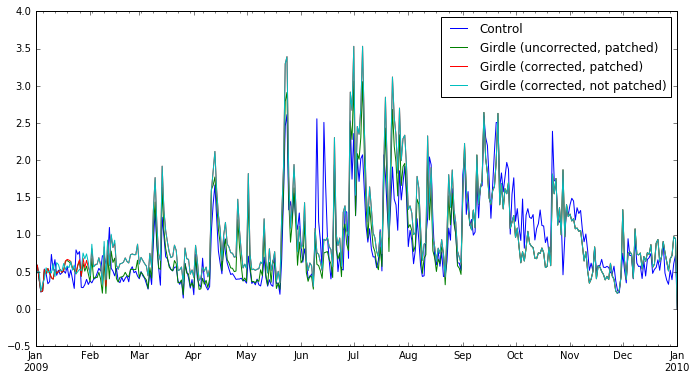

In [4]:
# Compare old data and the uncorrected ET data
plt.figure(figsize=( 11.5, 6 ))
dc.ET_mm_24hint_0.plot()
dg.ET_mm_24hint_0.plot() # LE uncorrected, patched
le_cor_p_dg.ET_mm_24hint_0.plot() # LE corrected, patched
le_cor_nop_dg.ET_mm_24hint_0.plot() # LE corrected, not patched
plt.legend(['Control', 'Girdle (uncorrected, patched)', 'Girdle (corrected, patched)', 'Girdle (corrected, not patched)'])

## Compare ET totals for each version of data

In [5]:
# ET
df_ET = pd.DataFrame( index = ['2009', 'HY 2009'], columns=['Control ET',
                      'Girdle ET(uncorr, patch)', 'Girdle ET(corr, patch)',
                      'Girdle ET(corr, no patch)'])

df_ET.loc['2009','Control ET'] = dc.ET_mm_24hint_0.sum()
df_ET.loc['2009','Girdle ET(uncorr, patch)'] = dg.ET_mm_24hint_0.sum()
df_ET.loc['2009','Girdle ET(corr, patch)'] = le_cor_p_dg.ET_mm_24hint_0.sum()
df_ET.loc['2009','Girdle ET(corr, no patch)'] = le_cor_nop_dg.ET_mm_24hint_0.sum()

# Hydrologic year - only Jan - Sept
wyidx = dc.index.month < 10
df_ET.loc['HY 2009','Control ET'] = dc.loc[wyidx].ET_mm_24hint_0.sum()
df_ET.loc['HY 2009','Girdle ET(uncorr, patch)'] = dg.loc[wyidx].ET_mm_24hint_0.sum()
df_ET.loc['HY 2009','Girdle ET(corr, patch)'] = le_cor_p_dg.loc[wyidx].ET_mm_24hint_0.sum()
df_ET.loc['HY 2009','Girdle ET(corr, no patch)'] = le_cor_nop_dg.loc[wyidx].ET_mm_24hint_0.sum()

In [6]:
# This is summed raw ET numbers
df_ET

,Control ET,"Girdle ET(uncorr, patch)","Girdle ET(corr, patch)","Girdle ET(corr, no patch)"
2009,318.534,321.459,366.095,366.757
HY 2009,240.091,248.877,293.514,294.175


Based on the above, the discrepancy doesn't appear to be due to the gapfilling (patch doesnt change numbers much). The correction however seems to really increase girdle ET numbers and uncorrected data is closer to the PJC value.

## Compare IRGA and HMP measurements

For corrected and uncorrected fluxall data. Remember that FC, LE and E are the only variables the bad irga regression corrections are applied to

In [7]:
# Load fluxall data

fa_path = '/home/greg/sftp/eddyflux/Fluxall_files/provisional/'

pjg_fa = ld.load_fluxall_file(fa_path + 'PJ_girdle/' + 'PJ_girdle_2009_fluxall.txt', 2009)
pjg_uncorr_fa = ld.load_fluxall_file(fa_path + 'PJ_girdle/' + 'PJ_girdle_2009_fluxall_lefc_uncorr.txt', 2009)
pjg_lecorr_fa = ld.load_fluxall_file(fa_path + 'PJ_girdle/' + 'PJ_girdle_2009_fluxall_le_corr.txt', 2009)
pjc_fa = ld.load_fluxall_file(fa_path + 'PJ/' + 'PJ_2009_fluxall.txt', 2009)

Parsing /home/greg/sftp/eddyflux/Fluxall_files/provisional/PJ_girdle/PJ_girdle_2009_fluxall.txt
Parsing /home/greg/sftp/eddyflux/Fluxall_files/provisional/PJ_girdle/PJ_girdle_2009_fluxall_lefc_uncorr.txt
Parsing /home/greg/sftp/eddyflux/Fluxall_files/provisional/PJ_girdle/PJ_girdle_2009_fluxall_le_corr.txt
Parsing /home/greg/sftp/eddyflux/Fluxall_files/provisional/PJ/PJ_2009_fluxall.txt


### H2O and CO2 mixing ratios (not corrected)

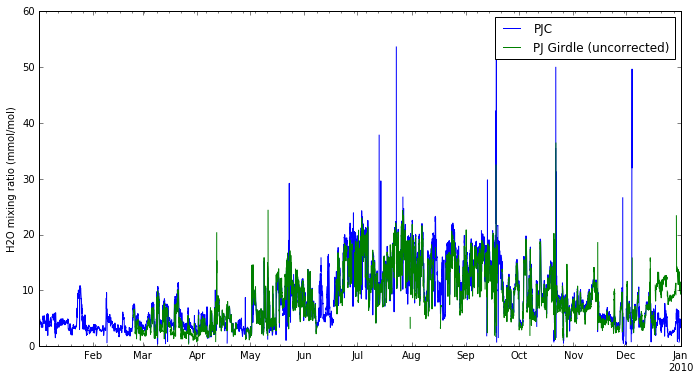

In [8]:
# H2O Mixing ratio from irga between control and girdle
plt.figure(figsize=( 11.5, 6 ))
pjc_fa.H2O_mean.plot()
pjg_fa.H2O_mean.plot()
plt.legend(['PJC', 'PJ Girdle (uncorrected)'])
plt.ylabel('H2O mixing ratio (mmol/mol)')

# IRGA at PJG seems to be reading a little lower, but not too much

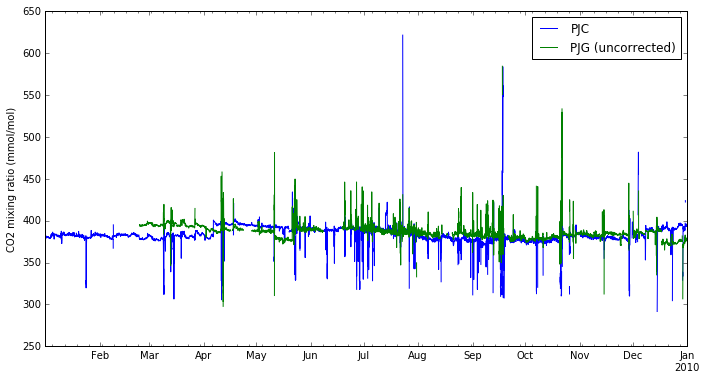

In [9]:
# CO2 mixing ratio from irga between control and girdle
plt.figure(figsize=( 11.5, 6 ))
pjc_fa.CO2_mean.plot()
pjg_uncorr_fa.CO2_mean.plot()
plt.legend(['PJC', 'PJG (uncorrected)'])
plt.ylabel('CO2 mixing ratio (mmol/mol)')


### H2O and CO2 fluxes (corrected for bad IRGA)

Second panel in these plots shows the correction size

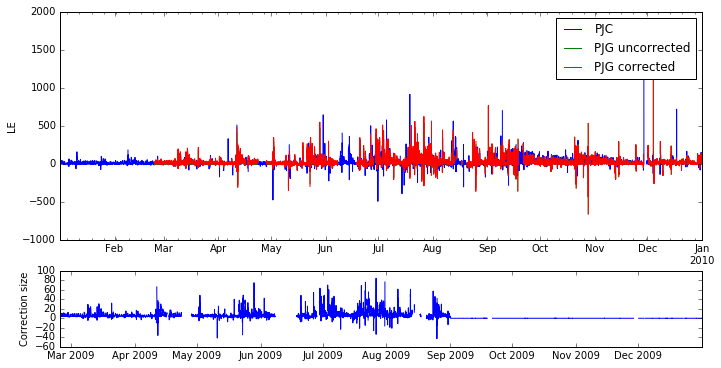

In [10]:
# Latent heat flux ( gets corrected )
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.figure(figsize=( 11.5, 6 ))
plt.subplot(gs[0])
pjc_fa.LatentHeat_raw.plot()
pjg_fa.LatentHeat_raw.plot()
pjg_lecorr_fa.LatentHeat_raw.plot()
plt.ylabel('LE')
plt.legend(['PJC', 'PJG uncorrected', 'PJG corrected'])
plt.subplot(gs[1])
plt.plot(pjc_fa.index, pjg_lecorr_fa.LatentHeat_raw - pjg_fa.LatentHeat_raw)
plt.ylabel('Correction size')

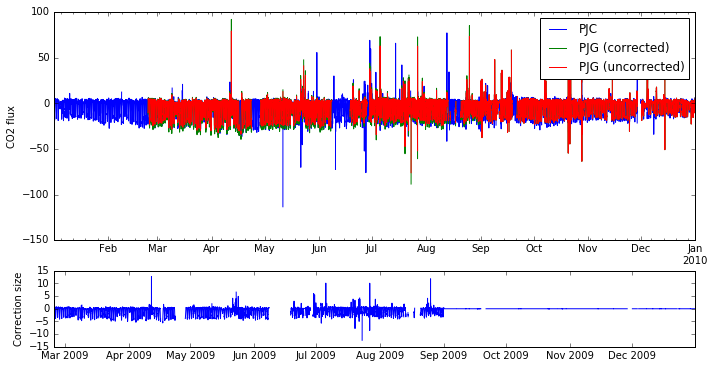

In [11]:
# Raw CO2 flux 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.figure(figsize=( 11.5, 6 ))
plt.subplot(gs[0])
pjc_fa.Fc_raw.plot()
pjg_fa.Fc_raw.plot()
pjg_uncorr_fa.Fc_raw.plot()
plt.ylabel('CO2 flux')
plt.legend(['PJC', 'PJG (corrected)', 'PJG (uncorrected)'])
plt.subplot(gs[1])
plt.plot(pjc_fa.index, pjg_fa.Fc_raw - pjg_uncorr_fa.Fc_raw)
plt.ylabel('Correction size')


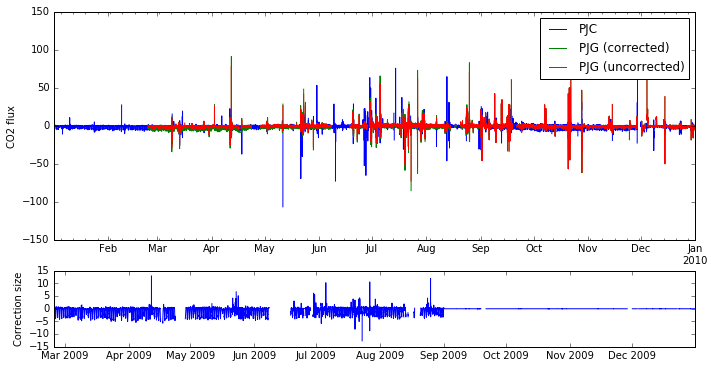

In [12]:
# Density and frequency corrected CO2 flux
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
plt.figure(figsize=( 11.5, 6 ))
plt.subplot(gs[0])
pjc_fa.Fc_raw_massman_ourwpl.plot()
pjg_fa.Fc_raw_massman_ourwpl.plot()
pjg_uncorr_fa.Fc_raw_massman_ourwpl.plot()
plt.ylabel('CO2 flux')
plt.legend(['PJC', 'PJG (corrected)', 'PJG (uncorrected)'])
plt.subplot(gs[1])
plt.plot(pjc_fa.index, pjg_fa.Fc_raw_massman_ourwpl - pjg_uncorr_fa.Fc_raw_massman_ourwpl)
plt.ylabel('Correction size')

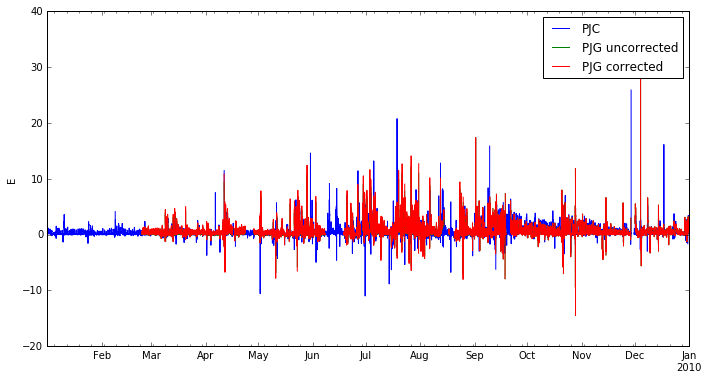

In [13]:
# H2O mass flux (E - corrected)
plt.figure(figsize=( 11.5, 6 ))
pjc_fa.E_raw.plot()
pjg_fa.E_raw.plot()
pjg_lecorr_fa.E_raw.plot()
plt.legend(['PJC', 'PJG uncorrected', 'PJG corrected'])
plt.ylabel('E')

### Convert IRGA mixing ratio to RH

In [14]:
# Convert H2O_mean to RH
# This is mmol/mol dry air (mixing ratio - pretty sure), which is calculated by
# UNM_dry_air_conversions and what UNM_flux_031010.m selects and sends an average of
def get_rH_from_mixingratio( w, T, P ):
    # Saturation vapor pressure from ArdenBuck eqn 
    es = 6.1121 * np.exp((18.678-(T/234.5))*(T/(257.14+T)))
    # Saturation mixing ratio & convert to mmol/mol 
    ws = 1000*(es/(P - es))
    # Calculate relative humidity from ratio of w to ws 
    rH = (w/ws) * 100
    # where T is temperature (C, from hmp), P is ambient pressure (hPa),
    # and w is H2O_mean from our irga (mmol/mol)
    return rH

(-5, 150)

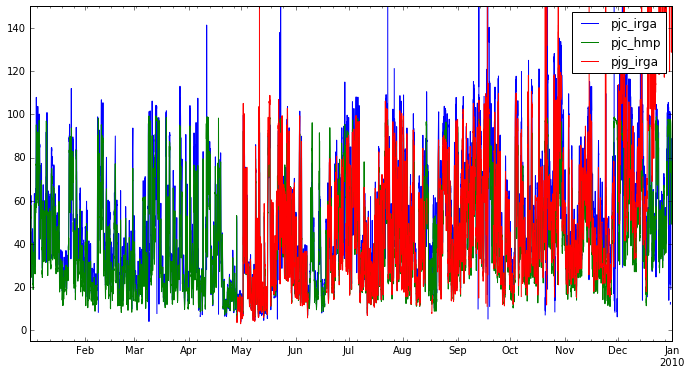

In [15]:
# Convert control and girdle irga H2O_mean values to RH and compare them
# Note that there is no RH from the HMP at PJG this year (not sure why currently)
pjc_rH_irga = get_rH_from_mixingratio( pjc_fa.H2O_mean, pjc_fa.AirTC_10_Avg, pjc_fa.press_Avg*10)
pjg_rH_irga = get_rH_from_mixingratio( pjg_fa.H2O_mean, pjg_fa.AirTC_6p85_Avg, pjg_fa.press_Avg*10)

plt.figure(figsize=( 11.5, 6 ))
pjc_rH_irga.plot()
pjc_fa.RH_10_Avg.plot()
pjg_rH_irga.plot()
#pjg_fa.h2o_hmp_mean_Avg.plot()
plt.legend(['pjc_irga', 'pjc_hmp', 'pjg_irga'])
plt.ylim([-5, 150])

# Both irgas seem to read a little above saturation sometimes but otherwise they are similar